<h1>Normalisation for the removal of batch effect</h1>

In [86]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.mongo_setup import pd_init
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating, Template
from immunova.flow.normalisation.normalise import Normalise
from immunova.flow.supervised_algo.utilities import calculate_reference_sample, find_common_features
from warnings import filterwarnings
from tqdm import tqdm_notebook
import matplotlib
import pandas as pd
import os
filterwarnings('ignore')
pd_init()

In [87]:
texp = FCSExperiment.objects(experiment_id='PD_T_PDMCs').get()

<h2>Calculate Reference Sample</h2>

In [88]:
exclude = ['142-09_pdmc_t',
 '210-14_pdmc_t',
 '273-01_pdmc_t',
 '276-01_pdmc_t',
 '286-03_pdmc_t',
 '298-01_pdmc_t',
 '305-01_pdmc_t',
 '308-02R_pdmc_t',
 '315-01_pdmc_t',
 '322-01_pdmc_t',
 '323-01_pdmc_t',
 '324-01_pdmc_t',
 '302-01_pdmc_t']

In [9]:
reference_sample = calculate_reference_sample(texp, exclude_samples=exclude)

Running comparisons for 165-09_pdmc_t
Running comparisons for 175-09_pdmc_t
Running comparisons for 209-03_pdmc_t
Running comparisons for 209-05_pdmc_t
Running comparisons for 239-02_pdmc_t
Running comparisons for 239-04_pdmc_t
Running comparisons for 251-07_pdmc_t
Running comparisons for 251-08_pdmc_t
Running comparisons for 254-04_pdmc_t
Running comparisons for 254-05_pdmc_t
Running comparisons for 255-04_pdmc_t
Running comparisons for 255-05_pdmc_t
Running comparisons for 264-02_pdmc_t
Running comparisons for 267-02_pdmc_t
Running comparisons for 286-04_pdmc_t
Running comparisons for 294-02_pdmc_t
Running comparisons for 294-03_pdmc_t
Running comparisons for 305-03_pdmc_t
Running comparisons for 306-01_pdmc_t
Running comparisons for 308-03R_pdmc_t
Running comparisons for 308-04_pdmc_t
Running comparisons for 310-01_pdmc_t
Running comparisons for 315-02_pdmc_t
Running comparisons for 318-01_pdmc_t
Running comparisons for 326-01_pdmc_t
Running comparisons for 237-06_pdmc_t
Running com

In [7]:
reference_sample

'288-02_pdmc_t'

In [5]:
reference_sample = '288-02_pdmc_t'

<h2>Normalise the first sample</h2>

In [89]:
all_samples = [x for x in texp.list_samples() if x not in exclude]

In [8]:
features = find_common_features(experiment=texp)

In [90]:
features = ['CD45RA',
 'Va7.2',
 'FSC-A',
 'FSC-H',
 'SSC-A',
 'CD161',
 'CD8',
 'CXCR3',
 'Vd2',
 'CD4',
 'CD3',
 'CD27',
 'PanGD',
 'L/D',
 'CCR7',
 'SSC-W']

In [93]:
all_samples[0]

'165-09_pdmc_t'

In [91]:
norm = Normalise(experiment=texp,
                source_id=all_samples[0],
                root_population='liveCD3',
                features=features,
                reference_sample=reference_sample,
                transform='log_transform')

setting scales using KNN
Scales: [1.3623430740255418, 2.7246861480510836, 5.449372296102167]
setting all scale weights to 1
Train on 884 samples, validate on 99 samples
Epoch 1/500
884/884 [==============================] - 1s 1ms/step - loss: 1.5952 - val_loss: 1.6328
Epoch 2/500
884/884 [==============================] - 0s 106us/step - loss: 1.5956 - val_loss: 1.6325
Epoch 3/500
884/884 [==============================] - 0s 111us/step - loss: 1.5838 - val_loss: 1.6324
Epoch 4/500
884/884 [==============================] - 0s 108us/step - loss: 1.5708 - val_loss: 1.6321
Epoch 5/500
884/884 [==============================] - 0s 108us/step - loss: 1.5558 - val_loss: 1.6318
Epoch 6/500
884/884 [==============================] - 0s 109us/step - loss: 1.5403 - val_loss: 1.6314
Epoch 7/500
884/884 [==============================] - 0s 118us/step - loss: 1.5256 - val_loss: 1.6309
Epoch 8/500
884/884 [==============================] - 0s 101us/step - loss: 1.5122 - val_loss: 1.6304
Epoch 9/5

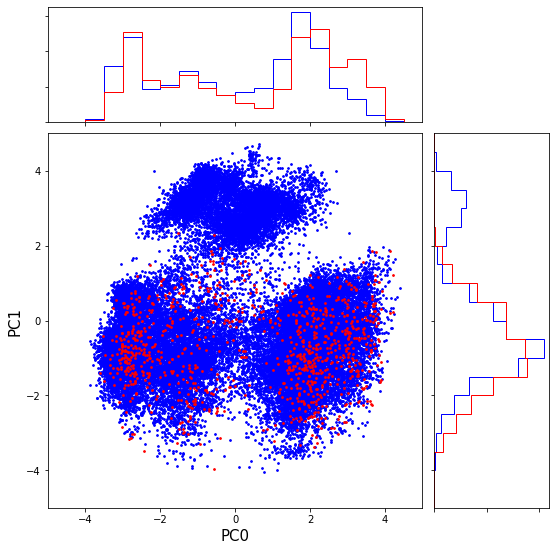

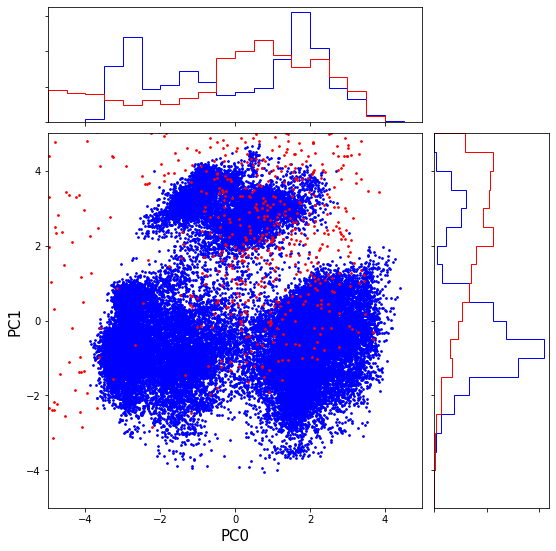

In [92]:
norm.calibrate(evaluate=True)

setting scales using KNN
Scales: [1.5270701099817046, 3.054140219963409, 6.108280439926818]
setting all scale weights to 1
Train on 225311 samples, validate on 25035 samples
Epoch 1/500
225311/225311 [==============================] - 24s 104us/step - loss: 0.3289 - val_loss: 0.8969
Epoch 2/500
225311/225311 [==============================] - 23s 102us/step - loss: 0.1904 - val_loss: 0.5524
Epoch 3/500
225311/225311 [==============================] - 23s 101us/step - loss: 0.1788 - val_loss: 0.2880
Epoch 4/500
225311/225311 [==============================] - 23s 102us/step - loss: 0.1726 - val_loss: 0.2332
Epoch 5/500
225311/225311 [==============================] - 22s 99us/step - loss: 0.1677 - val_loss: 0.2325
Epoch 6/500
225311/225311 [==============================] - 22s 99us/step - loss: 0.1646 - val_loss: 0.2237
Epoch 7/500
225311/225311 [==============================] - 22s 98us/step - loss: 0.1621 - val_loss: 0.2252
Epoch 8/500
225311/225311 [==============================] 

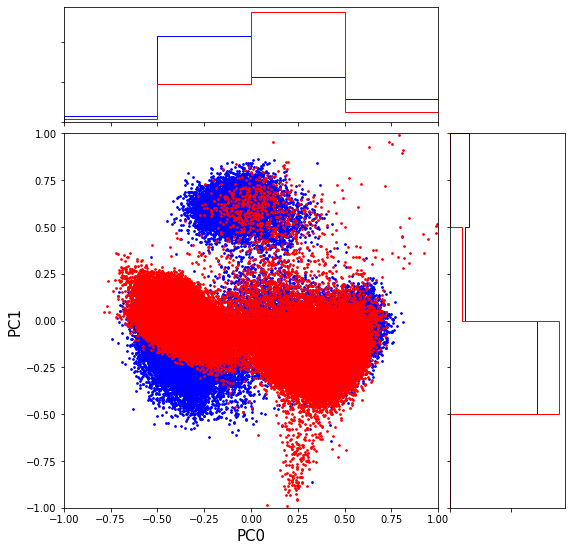

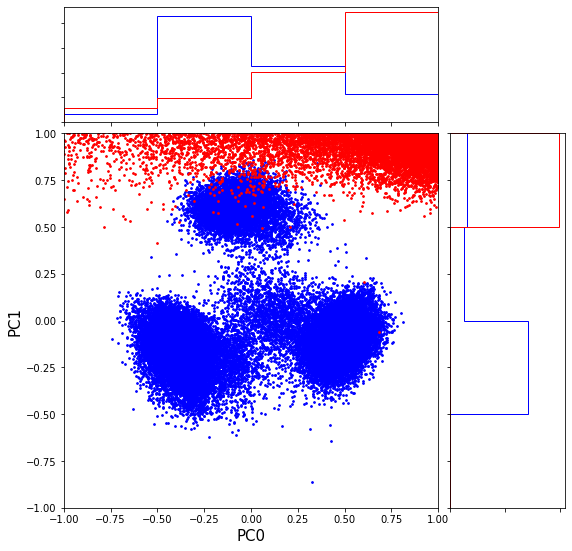

In [10]:
norm = Normalise(experiment=texp,
                source_id=all_samples[5],
                root_population='liveCD3',
                features=features,
                reference_sample=reference_sample)
norm.calibrate(evaluate=True)

In [11]:
all_samples[5]

'239-04_pdmc_t'

In [34]:
before = Gating(texp, '239-04_pdmc_t').get_population_df('liveCD3', transform=True)[features]

In [36]:
after = norm.model.net.predict(norm.source)
after = pd.DataFrame(after, columns=norm.source.columns)

In [74]:
norm.source.head()

,CD45RA,Va7.2,FSC-A,FSC-H,SSC-A,CD161,CD8,CXCR3,Vd2,CD4,CD3,CD27,PanGD,L/D,CCR7,SSC-W
1.0,0.181055,0.337403,0.870431,0.854916,0.722268,0.084629,0.584123,0.267479,0.117602,0.042347,0.519931,0.517637,0.170081,0.281808,0.232895,0.871554
7.0,0.175957,0.179144,0.847920,0.831624,0.655273,-0.014598,0.301975,0.229124,0.518376,0.648496,0.611295,0.599825,0.205225,0.213964,0.199211,0.871551
13.0,0.004308,0.481682,0.851108,0.832313,0.708734,0.233355,0.801454,0.255436,0.258114,0.208682,0.564372,0.316765,0.028340,0.333179,0.390697,0.871116
30.0,0.312198,0.480536,0.841444,0.826759,0.745479,0.032773,0.838596,0.307179,0.271673,0.028998,0.571577,0.241707,0.210408,0.257709,0.445042,0.871164
32.0,0.199527,0.485661,0.853837,0.838074,0.706223,0.423767,0.823092,0.349652,0.250738,0.133959,0.577354,0.459676,0.177995,0.296540,0.427497,0.871015


In [75]:
after.head()

,CD45RA,Va7.2,FSC-A,FSC-H,SSC-A,CD161,CD8,CXCR3,Vd2,CD4,CD3,CD27,PanGD,L/D,CCR7,SSC-W
0,0.763976,0.067196,3.575406,2.968716,2.340495,1.788518,-0.551665,0.519589,0.529483,0.898678,1.070345,0.620960,1.870327,0.782880,-0.090742,1.375300
1,1.313399,0.327457,3.620913,3.081455,2.824127,2.075408,0.278210,0.484720,1.072757,-0.136952,0.937068,0.966905,1.838424,0.692667,-0.229543,1.331153
2,1.145830,0.890926,3.643098,3.043163,2.612488,2.145071,0.928208,0.509460,0.313806,-0.386823,0.605499,1.110368,1.338188,0.754345,0.251169,1.231819
3,1.385206,0.733100,3.437362,2.947781,2.480293,0.933687,1.034194,0.509328,0.378549,-0.683053,0.468207,0.980517,1.178448,0.716206,0.280088,1.113433
4,1.088591,0.369266,3.511591,2.990709,2.396268,1.389595,0.702173,0.532865,0.256492,-0.216826,0.437322,1.003922,1.421749,0.757202,0.264002,1.146276


In [80]:
from sklearn import decomposition
features = [x for x in features if x != 'Time']

In [82]:
refdf = Gating(texp, reference_sample).get_population_df('liveCD3', transform=True)[features]
pca = decomposition.PCA()
pca.fit(before[features].values)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [83]:
target_sample_pca = pca.transform(refdf[features].values)
projection_before = pca.transform(before[features].values)
projection_after = pca.transform(after[features].values)

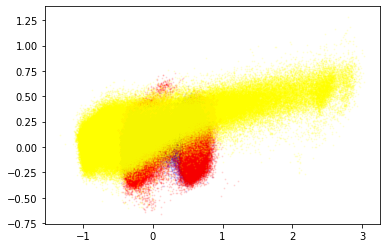

In [85]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(target_sample_pca[:,0], target_sample_pca[:,1], c='blue', s=1, alpha=0.1)
ax.scatter(projection_before[:,0], projection_before[:,1], c='red', s=1, alpha=0.1)
ax.scatter(projection_after[:,0], projection_after[:,1], c='yellow', s=1, alpha=0.1)
plt.show()

In [67]:
sbefore = before.sample(1000)
safter = after.sample(1000)
srefdf = refdf.sample(1000)
for df, n in zip([sbefore, safter, srefdf], ['Before', 'After', 'Ref']):
    df['label'] = n
f = features + ['label']
f.remove('Time')
sample = pd.concat([sbefore, safter, srefdf])[f]

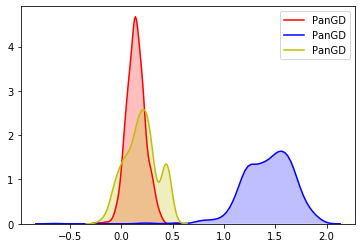

In [72]:
x = 'PanGD'
ax = sns.kdeplot(sbefore[x], shade=True, color="r")
ax = sns.kdeplot(safter[x], shade=True, color="b")
ax = sns.kdeplot(srefdf[x], shade=True, color="y")

In [69]:
norm.features

['CD45RA',
 'Va7.2',
 'FSC-A',
 'FSC-H',
 'SSC-A',
 'CD161',
 'CD8',
 'CXCR3',
 'Vd2',
 'CD4',
 'CD3',
 'CD27',
 'PanGD',
 'L/D',
 'CCR7',
 'SSC-W']

In [57]:
safter.head()

,CD45RA,Va7.2,FSC-A,FSC-H,SSC-A,CD161,CD8,CXCR3,Vd2,CD4,CD3,CD27,PanGD,L/D,CCR7,SSC-W,label
208873,1.061416,0.460323,3.589650,3.008554,2.565122,1.743004,0.368130,0.630045,0.475555,0.028324,0.700321,0.976310,1.526717,0.864950,0.192102,1.258689,After
232219,0.895766,0.112475,3.350979,2.811542,2.543832,1.698786,-1.215326,0.538019,1.378412,0.666391,1.300130,0.534521,1.896420,0.924891,0.004793,1.446847,After
101983,1.341976,1.061420,3.583581,3.002682,2.682994,2.187160,0.785946,0.486459,0.271870,-0.557852,0.701016,1.022094,1.222476,0.815306,-0.057686,1.289606,After
84641,1.278227,0.708221,3.492666,3.012356,2.706646,1.999152,0.666954,0.477437,1.021296,-0.605247,0.888100,0.979857,1.777088,0.730043,-0.128624,1.200487,After
4387,1.296029,0.325917,3.565593,3.048285,2.763386,1.847104,0.341128,0.528295,1.037202,-0.236993,0.918198,0.985178,1.806842,0.801462,-0.178023,1.273451,After


In [58]:
srefdf.head()

,CD45RA,Va7.2,Time,FSC-A,FSC-H,SSC-A,CD161,CD8,CXCR3,Vd2,CD4,CD3,CD27,PanGD,L/D,CCR7,SSC-W,label
3972643.0,0.231179,0.628587,0.834178,0.882649,0.861219,0.773618,0.577104,0.738603,0.301015,0.199174,0.044037,0.614710,0.147105,-0.110623,0.359401,0.322346,0.873653,Ref
1670605.0,0.209537,0.334169,0.724887,0.890388,0.871862,0.761653,0.538268,0.686043,0.330928,0.749738,0.190155,0.659275,0.437870,0.401408,0.349325,0.349586,0.875838,Ref
829628.0,0.437896,0.458927,0.656774,0.887531,0.864589,0.813022,0.015496,0.848100,0.326198,0.319884,0.020863,0.583530,0.524878,0.314199,0.393167,0.436749,0.876129,Ref
180784.0,-0.071303,0.325995,0.508796,0.898229,0.877560,0.773754,0.532808,0.474920,0.322453,0.757528,-0.039491,0.665063,0.477516,0.484997,0.383269,0.304057,0.873896,Ref
3990519.0,0.211288,0.332041,0.835053,0.892384,0.869132,0.783578,0.105772,0.314281,0.240479,0.346162,0.658870,0.618531,0.597610,0.122626,0.353452,0.598870,0.873696,Ref


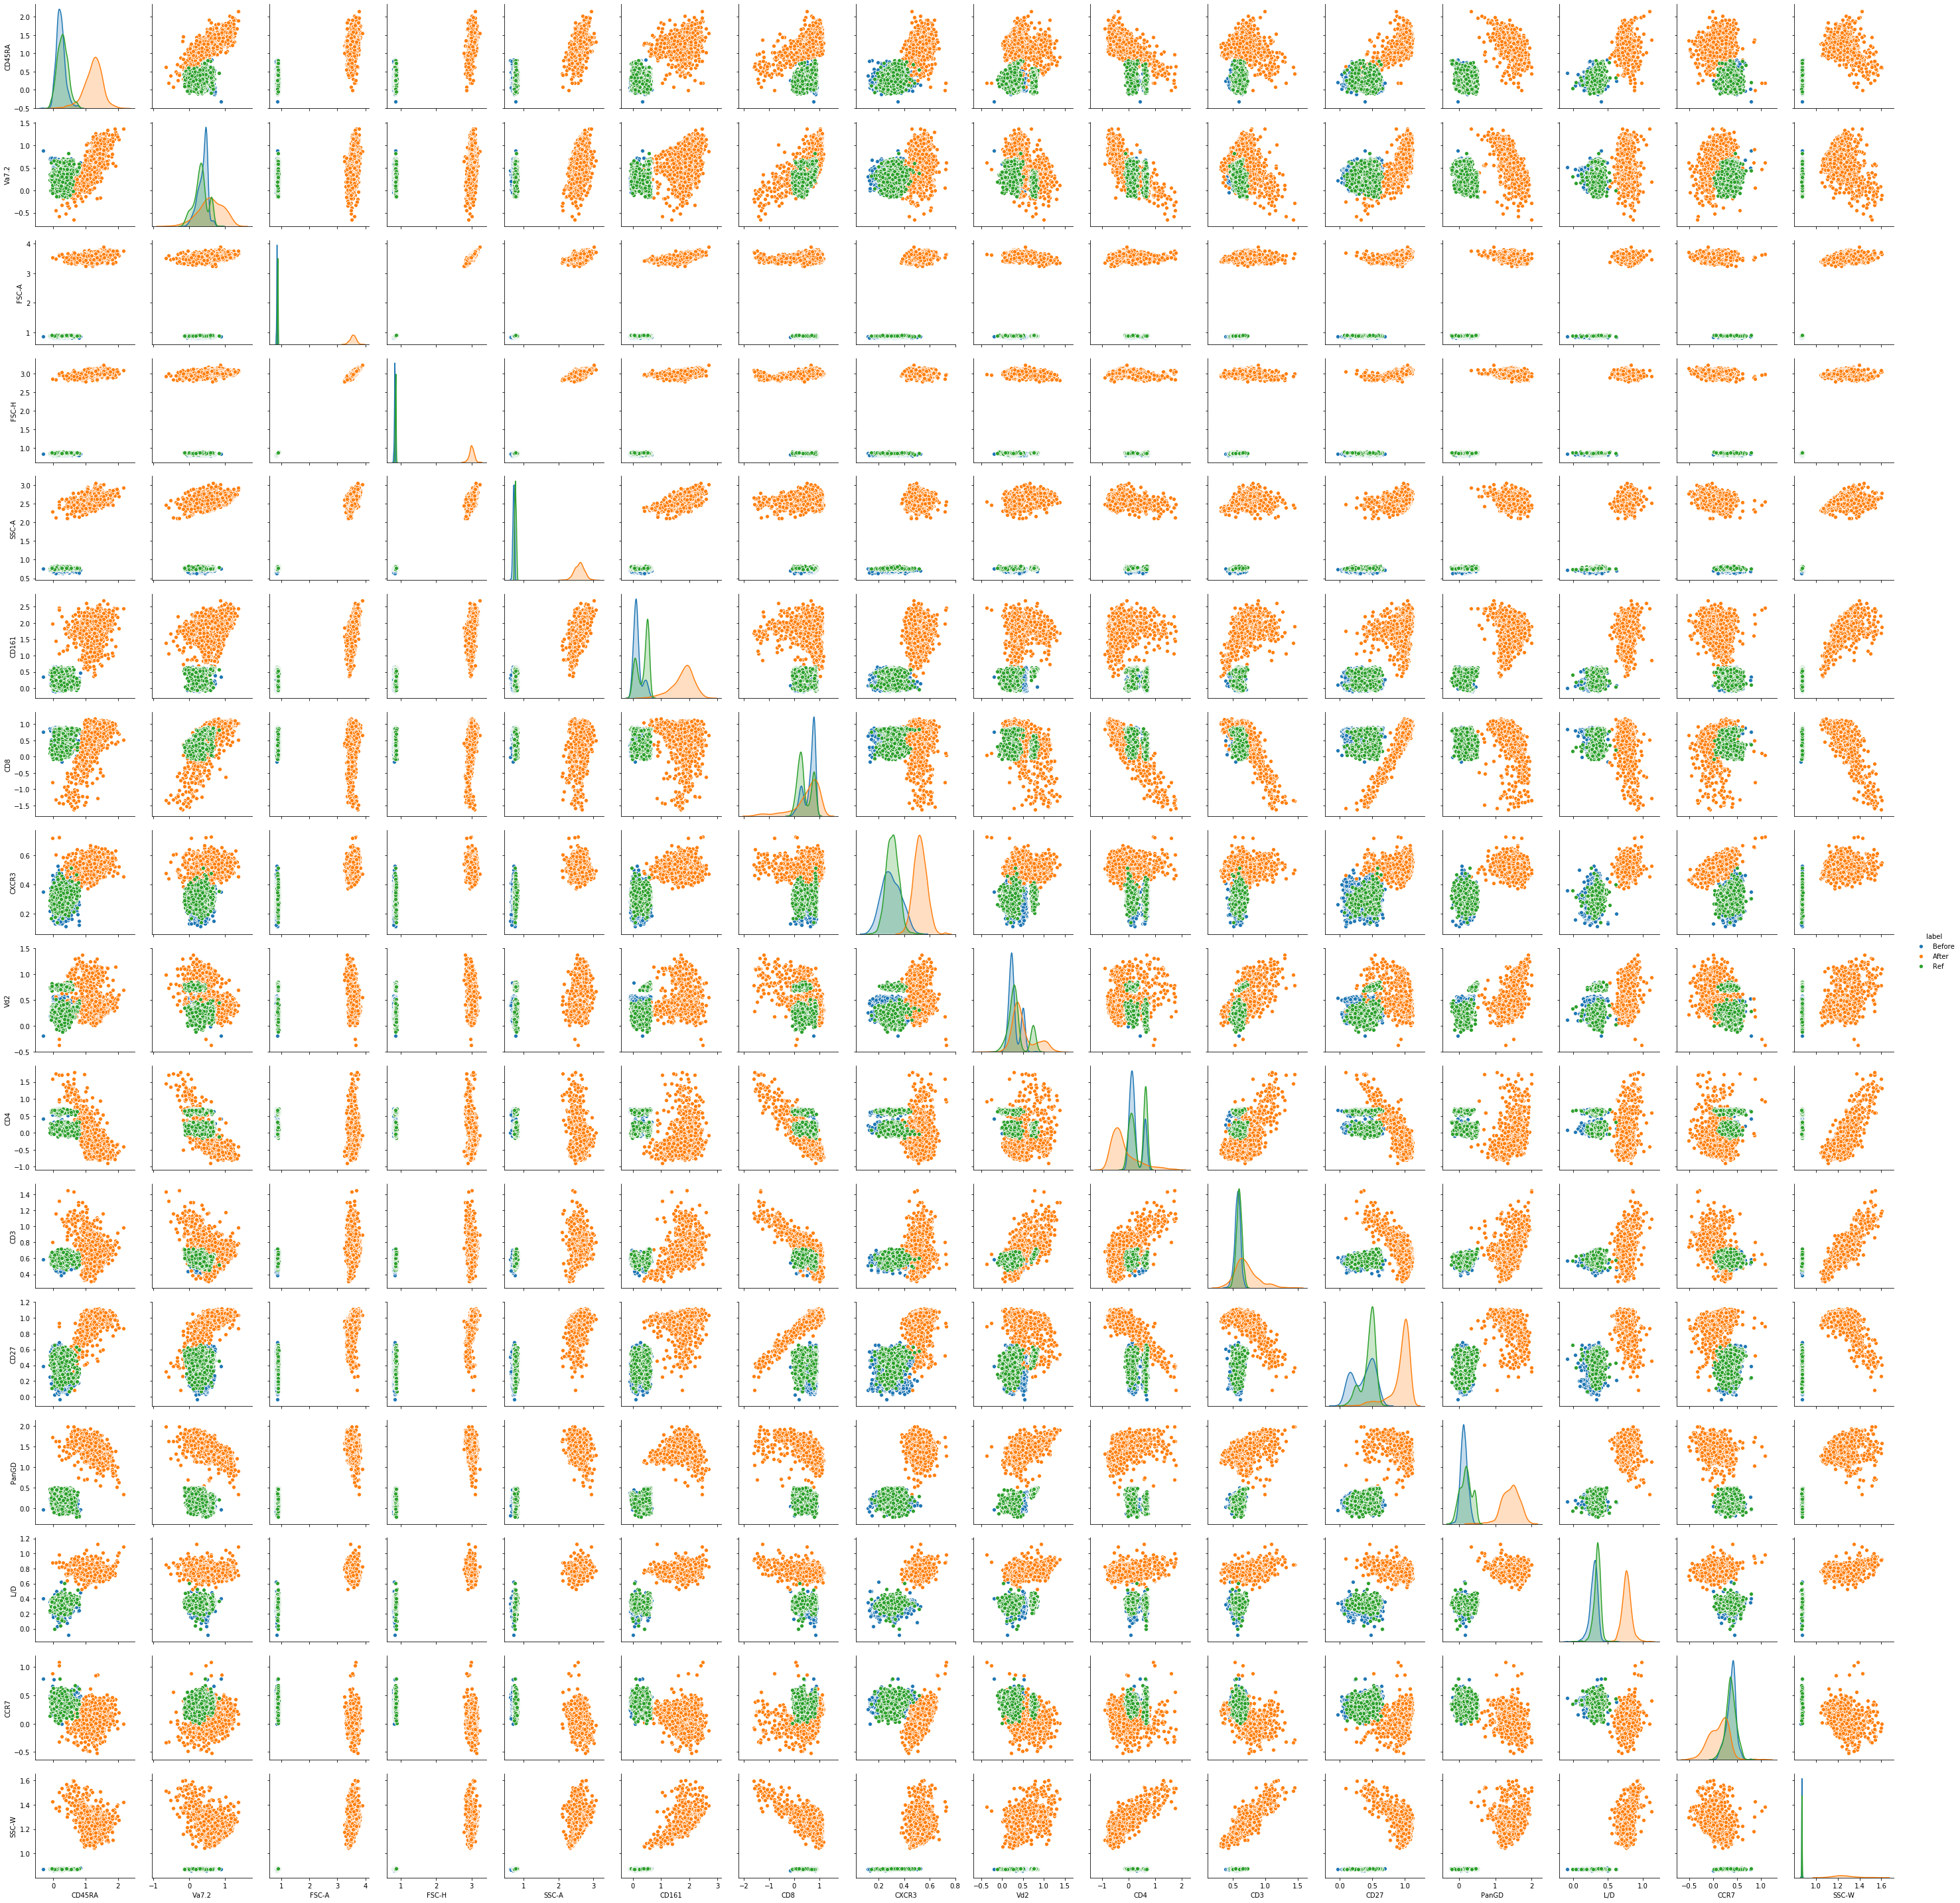

In [55]:
sns.pairplot(sample, hue="label")